In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
ativos = ["BPAC11.SA","ITUB3.SA","VALE3.SA","EGIE3.SA","WEGE3.SA"]

data_inicio = pd.to_datetime("2019-01-01")
data_fim = pd.to_datetime("2023-12-31")

pesos = np.array([0.2,0.2,0.2,0.2,0.2])

In [4]:
carteira = yf.download(ativos,start=data_inicio,end=data_fim)["Adj Close"]
carteira

[*********************100%%**********************]  5 of 5 completed


Ticker,BPAC11.SA,EGIE3.SA,ITUB3.SA,VALE3.SA,WEGE3.SA
Date,,,,,
2019-01-02,5.481548,25.633488,25.496422,34.850056,8.392294
2019-01-03,5.708294,26.474426,25.727770,33.424404,8.583664
2019-01-04,5.910825,26.669649,25.296970,35.600399,8.681684
2019-01-07,6.031903,26.504461,25.624058,35.409401,8.546320
2019-01-08,5.919579,26.804800,25.687878,35.750473,8.476310
...,...,...,...,...,...
2023-12-21,36.511269,44.422287,28.055042,76.970001,36.389999
2023-12-22,36.650700,44.570000,28.274769,76.389999,36.509998
2023-12-26,37.138714,44.790001,28.604359,76.660004,36.720001


In [5]:
retornos = carteira.pct_change()
retornos.dropna(inplace=True)
retornos

Ticker,BPAC11.SA,EGIE3.SA,ITUB3.SA,VALE3.SA,WEGE3.SA
Date,,,,,
2019-01-03,0.041365,0.032806,0.009074,-0.040908,0.022803
2019-01-04,0.035480,0.007374,-0.016745,0.065102,0.011419
2019-01-07,0.020484,-0.006194,0.012930,-0.005365,-0.015592
2019-01-08,-0.018622,0.011332,0.002491,0.009632,-0.008192
2019-01-09,0.001526,0.026611,0.009317,0.024423,0.011013
...,...,...,...,...,...
2023-12-21,0.000819,0.009964,0.004290,0.033293,0.006361
2023-12-22,0.003819,0.003325,0.007832,-0.007535,0.003298
2023-12-26,0.013315,0.004936,0.011657,0.003535,0.005752


In [6]:
#retorno do portifolio = somatorio(peso * retorno de cada)
retorno_carteira = (retornos*pesos).sum(axis=1)
retorno_portifolio = pd.DataFrame()
retorno_portifolio["Retornos"] = retorno_carteira
retorno_portifolio

,Retornos
Date,
2019-01-03,0.013028
2019-01-04,0.020526
2019-01-07,0.001253
2019-01-08,-0.000672
2019-01-09,0.014578
...,...
2023-12-21,0.010945
2023-12-22,0.002148
2023-12-26,0.007839


#Correlacao entre os retornos dos ativos


<Axes: xlabel='Ticker', ylabel='Ticker'>

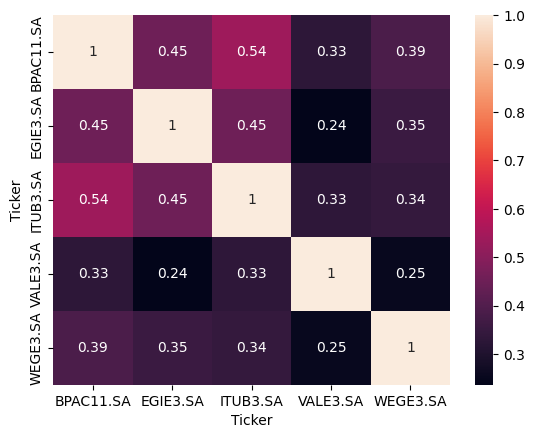

In [7]:
#risco da carteira
import seaborn as sns

corr = retornos.corr()
sns.heatmap(corr,annot=True)

#Matriz de covariancia

In [8]:
cov = retornos.cov()
cov

Ticker,BPAC11.SA,EGIE3.SA,ITUB3.SA,VALE3.SA,WEGE3.SA
Ticker,,,,,
BPAC11.SA,0.001038,0.000224,0.000322,0.000268,0.000300
EGIE3.SA,0.000224,0.000234,0.000129,0.000092,0.000130
ITUB3.SA,0.000322,0.000129,0.000349,0.000157,0.000154
VALE3.SA,0.000268,0.000092,0.000157,0.000642,0.000153
WEGE3.SA,0.000300,0.000130,0.000154,0.000153,0.000575


#Funcao de risco da carteira

In [9]:
def volatividade_carteira(precos,pesos,cov):
  volat_diaria = np.sqrt(np.dot(pesos.T,np.dot(cov,pesos)))

  volt_anualizada = volat_diaria*np.sqrt(252)
  return volt_anualizada



In [11]:
volatividade_carteira(carteira,pesos,cov) #

0.2597702443889416

#Comparacao com Benchmark

In [16]:
def benchmark_ibov(data_inicio,data_fim,df_precos):
  ibov = yf.download("^BVSP",start=data_inicio,end=data_fim)["Close"]
  df_precos = df_precos.pct_change()
  df_precos.fillna(0,inplace=True)
  df_precos = (1+df_precos).cumprod()
  df_precos =pd.Series((df_precos*pesos).sum(axis=1),name="Carteira")

  ibov_retornos = ibov.pct_change()
  ibov_retornos.fillna(0,inplace=True)
  benchmark_ibov = (1+ibov_retornos).cumprod()
  benchmark = pd.merge(df_precos,benchmark_ibov, how="inner", left_index=True,right_index=True)
  benchmark.rename(columns={"Close":"IBOV"},inplace=True)
  return benchmark.iloc[-1], benchmark.plot(figsize=(10,6))


[*********************100%%**********************]  1 of 1 completed


(Carteira    3.268954
 IBOV        1.474366
 Name: 2023-12-28 00:00:00, dtype: float64,
 <Axes: xlabel='Date'>)

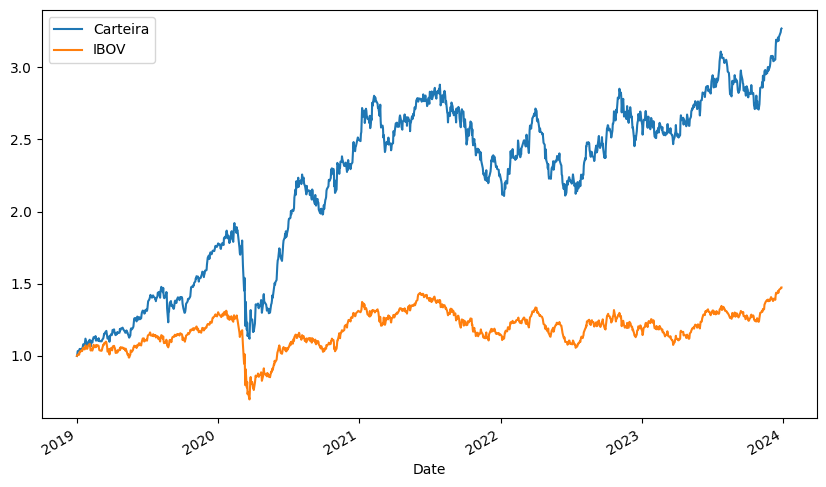

In [17]:
benchmark_ibov(data_inicio,data_fim,carteira)

In [ ]:
#carteira multiplicou seu capital por 3.26
#ibov multiplicou seu capital por 1.47
#https://www.youtube.com/watch?v=io67O4VElQE